# Group Project 2

| **S.no** 	| Team Member                         	|
|:--------:	|------------------------------	|
|     1    	| Disha Gandhi                 	|
|     2    	| Fernando Chapa            	|
|     3    	| Krish Engineer             	|
|     4    	| Kyle Tobia                	|

In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import seaborn as sns

#### Read the 2019 and 2020 Stock Data

In [16]:
df_2019 = pd.read_csv('stocks2019.csv')
df_2020 = pd.read_csv('stocks2020.csv')

#### Defining values of m in such a way that it starts at 5 as mentioned but ends according to the number of stocks

In [3]:
number_of_stocks_2019 = len(df_2019.iloc[:, 2:].columns)
number_of_stocks_2020 = len(df_2020.iloc[:, 2:].columns)
m_list = [5] + [i for i in range(10, number_of_stocks_2019 + 1, 10)]
m_list

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### Function to validate 2019 and 2020 stock quantities

In [4]:
def validation(stocks_2019, stocks2020):

    # Validation 1: Minimum number of stocks should always be greater than 5
    if min(stocks_2019, stocks2020) < 5:
        raise SystemExit('The number of stocks in either 2019 or 2020 is less than 5. Please enter more data before proceeding ahead')

    # Validation 2: 2019 and 2020 should have the same number of stocks for the performance of weights to be compared
    elif stocks_2019 != stocks2020:
        raise SystemExit('2019 and 2020 do not have the same number of stocks. Please make sure the stock count is same before proceeding ahead')
        

### Function to calulate daily  returns and the similarity matrix

In [5]:
def returns_and_similarity(df):
    
    # Setting date as the index to calculate returns
    df.set_index('X', inplace = True)

    # Convert to Returns and Remove the First Row since Returns are Null
    daily_returns = df.pct_change()
    daily_returns = daily_returns[1:]

    # Calculate Correlation Matrix between the Component Stocks
    p = daily_returns.iloc[:,1:].corr()
    
    return daily_returns, p

### Function having Gurobi Optimizer

In [6]:
def optimizer(obj, A, b, sense, rule, vtype, ub, lb):
    
    Model = gp.Model()
    ModX = Model.addMVar(len(obj), vtype = vtype, ub = ub, lb = lb) 
    ModCon = Model.addMConstrs(A, ModX, sense, b)
    if rule == 'MAX':
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE)
    if rule == 'MIN':
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)  
    Model.Params.OutputFlag = 0
    
    # Set Gurobi time limit in seconds
    time_limit = 3600

    Model.Params.TimeLimit = time_limit
    Model.optimize()
    
    return Model.objVal, ModX.x

### Function for Stock Selection

$$ \underset{x,y}max \sum_{i=1}^n \sum_{i=1}^n \rho_{ij}x_{ij} $$
$$ s.t. \sum_{j=1}^n y_j = m $$ 
$$ \sum_{j=1}^n x_{ij} = 1 \; for \; i = 1,2,...,n $$
$$ x_{ij} \leq y_j \; for \; i,j = 1,2,...,n $$
$$ x_{ij} > 0, y_j \in \{0,1\} $$

In [7]:
def stock_selection(m, p, df):
    
    # Filter out Index from Input DataFrame
    stocks = df.iloc[:, 1:]
    total_stocks = len(p)
    N = total_stocks

    #### Setting the OBJECTIVE Array to Maximize the Similarity between the n Stocks and their Representatives in the Fund

    # Objective contains (N*N) x and N y Binary Decision Variables
    
    obj = []
    for i in range(N):
        for j in range(N):
            obj.append(p.iloc[i,j])
    obj = np.array(obj+[0]*N)

    #### Defining the CONSTRAINTS to select ideal stocks for the fund
    
    A = np.zeros((N + N**2 + 1 , N**2 + N))
    b = np.zeros(N + N**2 + 1)
    sense = np.array([''] * (N + N**2 + 1))

    row = 0
    
    # Constraint 1: Select exactly m stocks for the Fund
    A[row, N*N:] = 1
    b[row] = m
    sense[row] = '='
    
    row += 1

    # Constraint 2: Each stock i has exactly one representative stock j in the Index
    for i in range(1, N+1):
        for j in range((i-1)*N, (i-1)*N + N):
            A[row,j] = 1
        b[row] = 1
        sense[row] = '='
        row += 1

    # Constraint 3: stock i is best represented by stock j only if j is in the Fund
    for i in range(0, N):
        for j in range(0, N):
            A[row, i*N + j] = 1
            A[row, N*N + j] = -1
            b[row] = 0
            sense[row] = '<'
            row += 1

    #### Setting the right VARIABLE type to Binary

    vtype = ['B'] * len(obj)
    
    #### Running GUROBI Optimization

    resultant_objective, resultant_decision_variables = optimizer(obj, A, b, sense, 'MAX', vtype, ub=None, lb=None)

    # Extract only y variable values
    stocks_to_be_selected = resultant_decision_variables[N*N:]

    # Find index of stocks which should be selected in the Portfolio and finding their names
    selected_stock_indexes = np.where(stocks_to_be_selected == 1)[0].tolist()
    stock_names = stocks.iloc[:,selected_stock_indexes].columns.tolist()
    
    return selected_stock_indexes, stock_names

### Function for Calculating Portfolio Weights

$$ \underset{w}min \sum_{t=1}^T | q_t - \sum_{i=1}^m w_i r_{it}| $$
$$ s.t. \sum_{i=1}^m w_i = 1 $$
$$ q_t - \sum_{i=1}^m w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ - q_t + \sum_{i=1}^m w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0 $$

In [8]:
def calculating_weights(df, m, stock_names):
    
    df_stock_daily_returns = df[stock_names]
    df_index_returns = pd.DataFrame(df.iloc[:,0])

    # Total Number of Dates i.e Total Number of returns to be minimized
    T = len(df_stock_daily_returns)

    #### Setting the OBJECTIVE Array to Minimize the difference between the index returns and weighted stock returns for any given year
    
    # Objective contains m (number of stocks) and T (total daily returns) Decision Variables
    obj = np.array([0] * m + [1] * T)
    
    #### Defining the CONSTRAINTS to calculate ideal stocks for the fund

    A = np.zeros((2*T + 1, m + T))
    b = np.zeros(2*T + 1)
    sense = np.array([''] * (2*T + 1))
    
    # Constraint 1: Sum of all Weights is equal to 1
    A[0, :m] = 1
    b[0] = 1
    sense[0] = '='

    # Constraint 2&3: Dissolving Non-linearity of Absolute function into two linear Constraints
    for t in range(1, T+1):
        A[t, 0:m] = df_stock_daily_returns.iloc[t-1].tolist()
        A[t, m+t-1] = 1 
        b[t] = df_index_returns.iloc[t-1][0]
        sense[t] = '>'

        A[t+T, 0:m] = [i * (-1) for i in df_stock_daily_returns.iloc[t-1].tolist()]
        A[t+T, m+t-1] = 1
        b[t+T] = (-1)*df_index_returns.iloc[t-1][0]
        sense[t+T] = '>'

    #### Running GUROBI Optimization
    
    resultant_objective, resultant_decision_variables = optimizer(obj, A, b, sense, 'MIN', vtype = None, ub = None, lb = None)

    # Extracting only the stock weights
    stock_weights = resultant_decision_variables[:m]

    return stock_weights

### Function for Calculating Portfolio Performance

In [9]:
def portfolio_performance(df, stock_names, stock_weights):
    
    df_stock_daily_returns = df[stock_names]
    
    portfolio_returns = []
    
    for i in range(len(df_stock_daily_returns)):
        
        # Calculate weighted portfolio returns for each date
        
        returns_per_stock = 0
        for j in range(len(stock_names)):
            returns_per_stock = returns_per_stock + stock_weights[j] * df_stock_daily_returns[stock_names[j]].iloc[i]
        portfolio_returns.append(returns_per_stock)
    
    # Calculate Difference between Index and Weight Portfolio Returns
    return_differences = np.abs(df.iloc[:, 0] - portfolio_returns)
    performance = sum(return_differences)
    
    return performance

### Function for Calculating Portfolio Weights ignoring Stock Selection

$$ \underset{w}min \sum_{t=1}^T d_t $$
$$ OR  $$
$$\underset{w} min \sum_{t=1}^T | q_t - \sum_{i=1}^n w_i r_{it}|$$
$$ s.t. \sum_{i=1}^n w_i = 1 $$
$$ \sum_{i=1}^n y_i = m $$
$$ w_i - My_i \leq 0 \; for \; i = 1,2,...,n $$
$$ q_t - \sum_{i=1}^n w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ - q_t + \sum_{i=1}^n w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0, y_i \in \{0,1\} $$

In [10]:
def portfolio_weights_ignoring_stock_selection(m, df_19, df_20):
    
#     returns = df.copy()
#     returns_20 = df_cy.copy()
    
    # Total Number of Dates i.e Total Number of returns to be minimized
    T = len(df_19)

    # Total Number of Stocks
    n = len(df_19.columns) - 1

    # value of Big M (smallest value we can use is 1)
    M = 1

    #### Setting the OBJECTIVE Array to Minimize the Difference between the Index Return and the Weighted Portfolio Return
    
    # Objective contains w(weights), y(stock present or not) and T(number of returns to be minimized) Decision Variables
    obj = np.array([0] * n + [0] * n + [1] * T)

    #### Defining the CONSTRAINTS to calculate ideal stocks for the fund

    A = np.zeros((1 + 1 + n + (T * 2), n + n + T))
    b = np.zeros(1 + 1 + n + (T * 2))
    sense = np.array(['<'] * (1 + 1 + n + (T * 2)))

    # Constraint 1: Sum of all weights is equal to 1
    A[0, :n] = 1
    b[0] = 1
    sense[0] = '='

    # Constraint 2: Sum of all stocks should be equal to m
    A[1, n : 2*n] = 1
    b[1] = m
    sense[1] = '='

    # Constraint 3: Big M Constraint
    for i in range(n):
        A[2 + i, i] = 1
        A[2 + i, i + n] = -1 #As M is set to 1

    # Constraint 4 & 5: Dissolving Non-linearity of Absolute function into two linear Constraints
    for i in range(len(df_19)):
        for j in range(n):
            A[2*i + 1 + n + 1, j] = df_19.iloc[i, j+1]
            A[2*i + 2 + n + 1, j] = df_19.iloc[i, j+1]
        A[2*i + 1 + n + 1, n + n + i] = 1
        A[2*i + 2 + n + 1, n + n + i] = -1
        b[2*i + 1 + n + 1] = df_19.iloc[i].iloc[0]
        b[2*i + 2 + n + 1] = df_19.iloc[i].iloc[0]
        sense[2*i + 1 + n + 1] = '>'
        sense[2*i + 2 + n + 1] = '<'

    #### Setting the right VARIABLE type

    vtype = ['C']*n + ['B']*n + ['C']*T

    #### Running GUROBI Optimization

    resultant_objective, resultant_decision_variables = optimizer(obj, A, b, sense, 'MIN', vtype, ub = None, lb = None)
    
    # Extract only the Stock Weights
    weights = resultant_decision_variables[:n]
    
    # Calculate in-sample Portfolio Performance i.e testing weights calculated from 2019 on 2019 returns itself
    df_19['Net Value'] = 0
    
    for i in range(n):
        df_19['Net Value'] = df_19['Net Value'] + weights[i] * df_19.iloc[:, i+1]
    
    # Subtracting calculated weighted returns from index returns
    df_19['Performance'] = df_19.iloc[:,0] - df_19['Net Value']
    df_19['Performance'] = df_19['Performance'].abs()
    performance_2019 = df_19['Performance'].sum()
    
    # Calculate out-of-sample Portfolio Performance i.e testing weights calculated from 2019 on 2019 returns itself
    df_20['Net Value'] = 0

    for i in range(n):
        df_20['Net Value'] = df_20['Net Value'] + weights[i] * df_20.iloc[:, i+1]
    
    # Subtracting calculated weighted returns from 2019 with index returns from 2020
    df_20['Performance'] = df_20.iloc[:,0] - df_20['Net Value']
    df_20['Performance'] = df_20['Performance'].abs()
    performance_2020 = df_20['Performance'].sum()
    
    return performance_2019, performance_2020

We will here onwards define the steps performed in order to execute a successful portfolio performance calculation.

1) We first generated the matrix for end of day closing value for each stock by reading the csv for each day for 2019 and 2020.

2) A list of possible values for m is computed which is basically how many stocks are to be included in the portfolio.

3) We validated the counts of unique stocks(tickers) in both the years using Validation function.

4) We calculated daily returns for both the years and generated a similarity matrix on those returns using Returns and Similarity function.

5) We then evaluate which stocks should be included based on the similarity score using stock selection function involving Gurobi optimization on the listed constraints.

6) Post which weights of those stocks are calculated on 2019 stocks data using calculating weights function involving again Gurobi Optimization on the listed constraints.

7) We then evaluate portfolio performance for both 2019 and 2020 data using different values of m and weughts calculated above in 6th.

8) Another method is then applied for portfolio performance evaluation where in the stocks are not selected based on similarity but just chosen based on weightage and MIP with different kinds of constraints. The only thing different here is there is no process for stock selection, and hence they jump directly to finding the weights of stocks for different number of stocks.

In [17]:
#validating 2019 and 2020 data
validation(number_of_stocks_2019, number_of_stocks_2020)

# Calculating Returns and Similarity Matrix for 2019 and 2020 stock data
df_2019_returns, p_2019 = returns_and_similarity(df_2019)
df_2020_returns, p_2020 = returns_and_similarity(df_2020)

# Create Performances table for each value of m
df_performance_with_stock_selection = pd.DataFrame(columns = ['Number of Stocks', '2020 Performance', '2019 Performance'])
df_performance_without_stock_selection = pd.DataFrame(columns = ['Number of Stocks', '2020 Performance', '2019 Performance'])

################ Calculate Portfolio Performances using the Stock Selection Method ###############

for m in m_list:
    stock_indexes, stock_names = stock_selection(m, p_2019, df_2019_returns)
    stock_weights = calculating_weights(df_2019_returns, m, stock_names)
    performance_2019 = portfolio_performance(df_2019_returns, stock_names, stock_weights)
    performance_2020 = portfolio_performance(df_2020_returns, stock_names, stock_weights)
    
    # Store Performance Results in a DataFrame
    df_performance_with_stock_selection.loc[len(df_performance_with_stock_selection)] = [m, performance_2020, performance_2019]

################# Calculate Portfolio Performances without the Stock Selection Method ##############

# Check if downloaded CSV already exists
if Path('portfolio_performance_without_stock_selection.csv').exists():
    df_performance_without_stock_selection = pd.read_csv('portfolio_performance_without_stock_selection.csv').iloc[:,1:]
else:

    for m in m_list:
        print('m:', m)
        performance_2019, performance_2020 = portfolio_weights_ignoring_stock_selection(m, df_2019_returns, df_2020_returns)
        
        # Store performance results in a dataframe
        df_performance_without_stock_selection.loc[len(df_performance_without_stock_selection)] = [m, performance_2020, performance_2019]
        
    # Store performance results in a CSV
    df_performance_without_stock_selection.to_csv('portfolio_performance_without_stock_selection.csv')

#### Performance Results without stock selection method over a range of m values for 2019 and 2020 both

In [19]:
df_performance_without_stock_selection

,Number of Stocks,2019 Performance,2020 Performance
0,5,0.515131,0.641539
1,10,0.304220,0.573443
2,20,0.178125,0.386181
3,30,0.113519,0.338392
4,40,0.081334,0.323223
5,50,0.066452,0.260226
6,60,0.055128,0.271527
7,70,0.047743,0.247341
8,80,0.045227,0.249143
9,90,0.044911,0.250194


#### Performance Results with stock selection method over a range of m values for 2019 and 2020 both

In [20]:
df_performance_with_stock_selection

,Number of Stocks,2020 Performance,2019 Performance
0,5.0,0.869670,0.789178
1,10.0,0.831317,0.686533
2,20.0,0.652338,0.478836
3,30.0,0.549085,0.418015
4,40.0,0.587312,0.370517
5,50.0,0.581148,0.332540
6,60.0,0.819424,0.344890
7,70.0,0.402497,0.169824
8,80.0,0.386431,0.147683
9,90.0,0.247582,0.053779


#### Plot of Performance vs Number of Stocks for both Methods

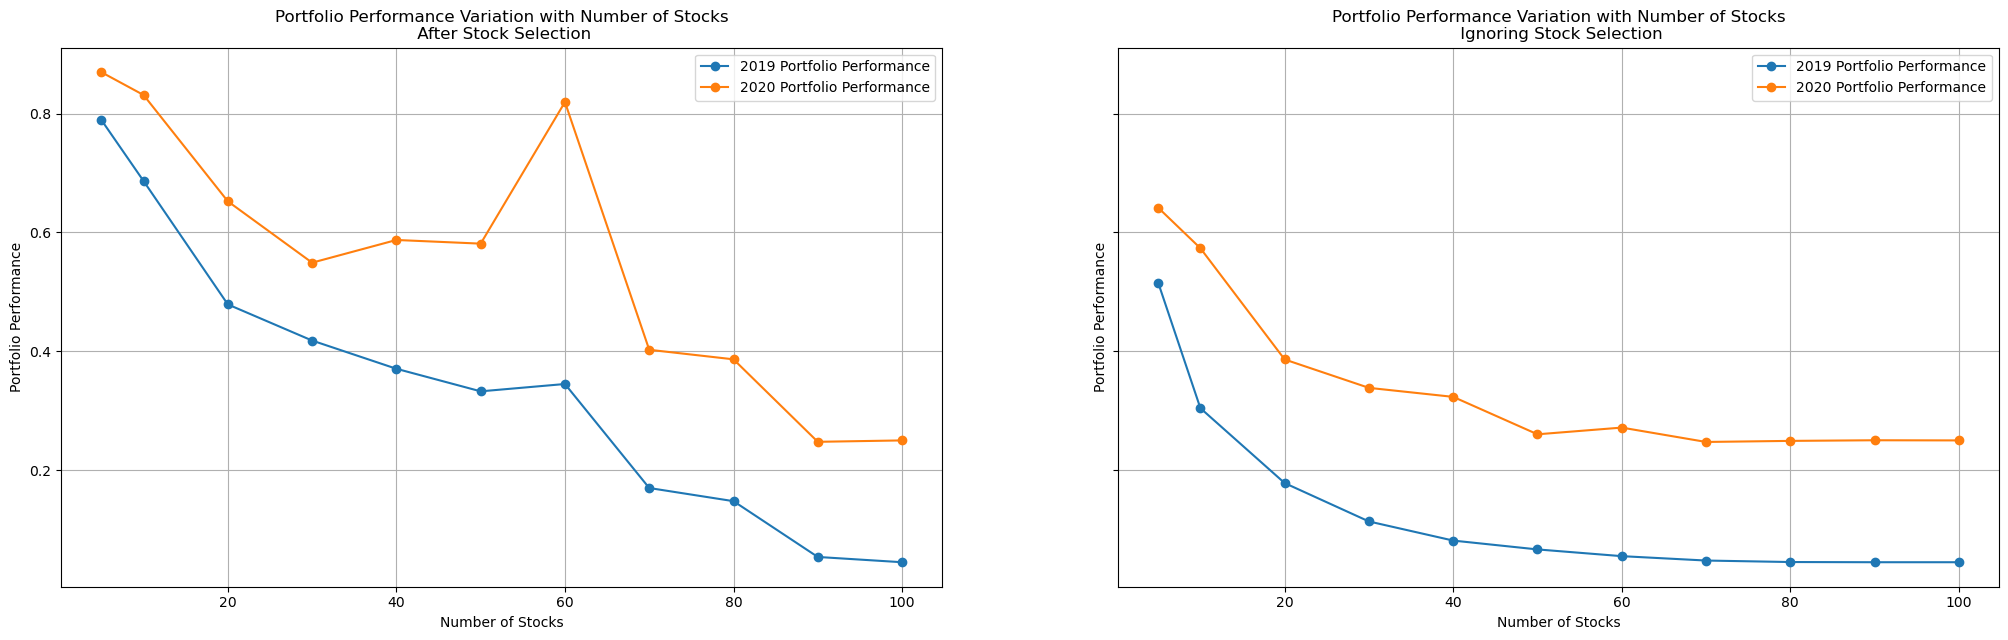

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize = (25,7), sharey = True, nrows = 1, ncols = 2)

ax1.plot(df_performance_with_stock_selection['Number of Stocks'], df_performance_with_stock_selection['2019 Performance'], marker = 'o', label = '2019 Portfolio Performance')
ax1.plot(df_performance_with_stock_selection['Number of Stocks'], df_performance_with_stock_selection['2020 Performance'], marker = 'o', label = '2020 Portfolio Performance')
ax1.set_title('Portfolio Performance Variation with Number of Stocks\n After Stock Selection')
ax1.set_xlabel('Number of Stocks')
ax1.set_ylabel('Portfolio Performance')
ax1.grid()
ax1.legend()

ax2.plot(df_performance_without_stock_selection['Number of Stocks'], df_performance_without_stock_selection['2019 Performance'], marker = 'o', label = '2019 Portfolio Performance')
ax2.plot(df_performance_without_stock_selection['Number of Stocks'], df_performance_without_stock_selection['2020 Performance'], marker = 'o', label = '2020 Portfolio Performance')
ax2.set_title('Portfolio Performance Variation with Number of Stocks\n Ignoring Stock Selection')
ax2.set_xlabel('Number of Stocks')
ax2.set_ylabel('Portfolio Performance')
ax2.legend()
ax2.grid()

plt.show()

#### Index Returns for 2019 and 2020

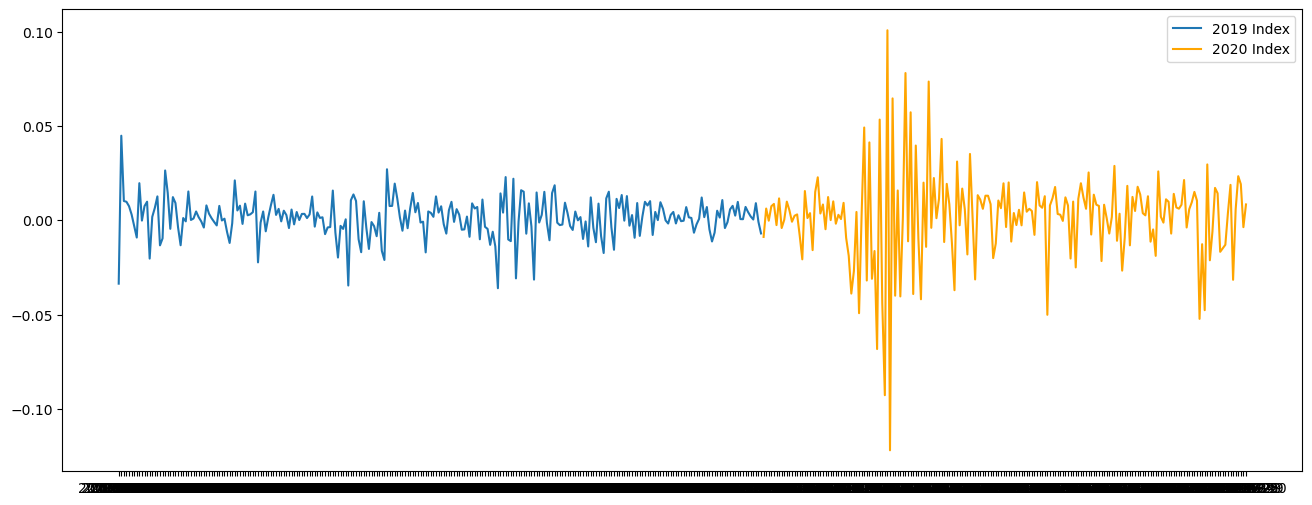

In [36]:
plt.figure(figsize=(16,6))
plt.plot(df_2019_returns['NDX'], label='2019 Index')
plt.plot(df_2020_returns.set_index(df_2020_returns['NDX'].index)['NDX'], label = '2020 Index', color='orange')
plt.legend()

#### Heatmap to show correlation/similarity in returns of stocks for 2019 

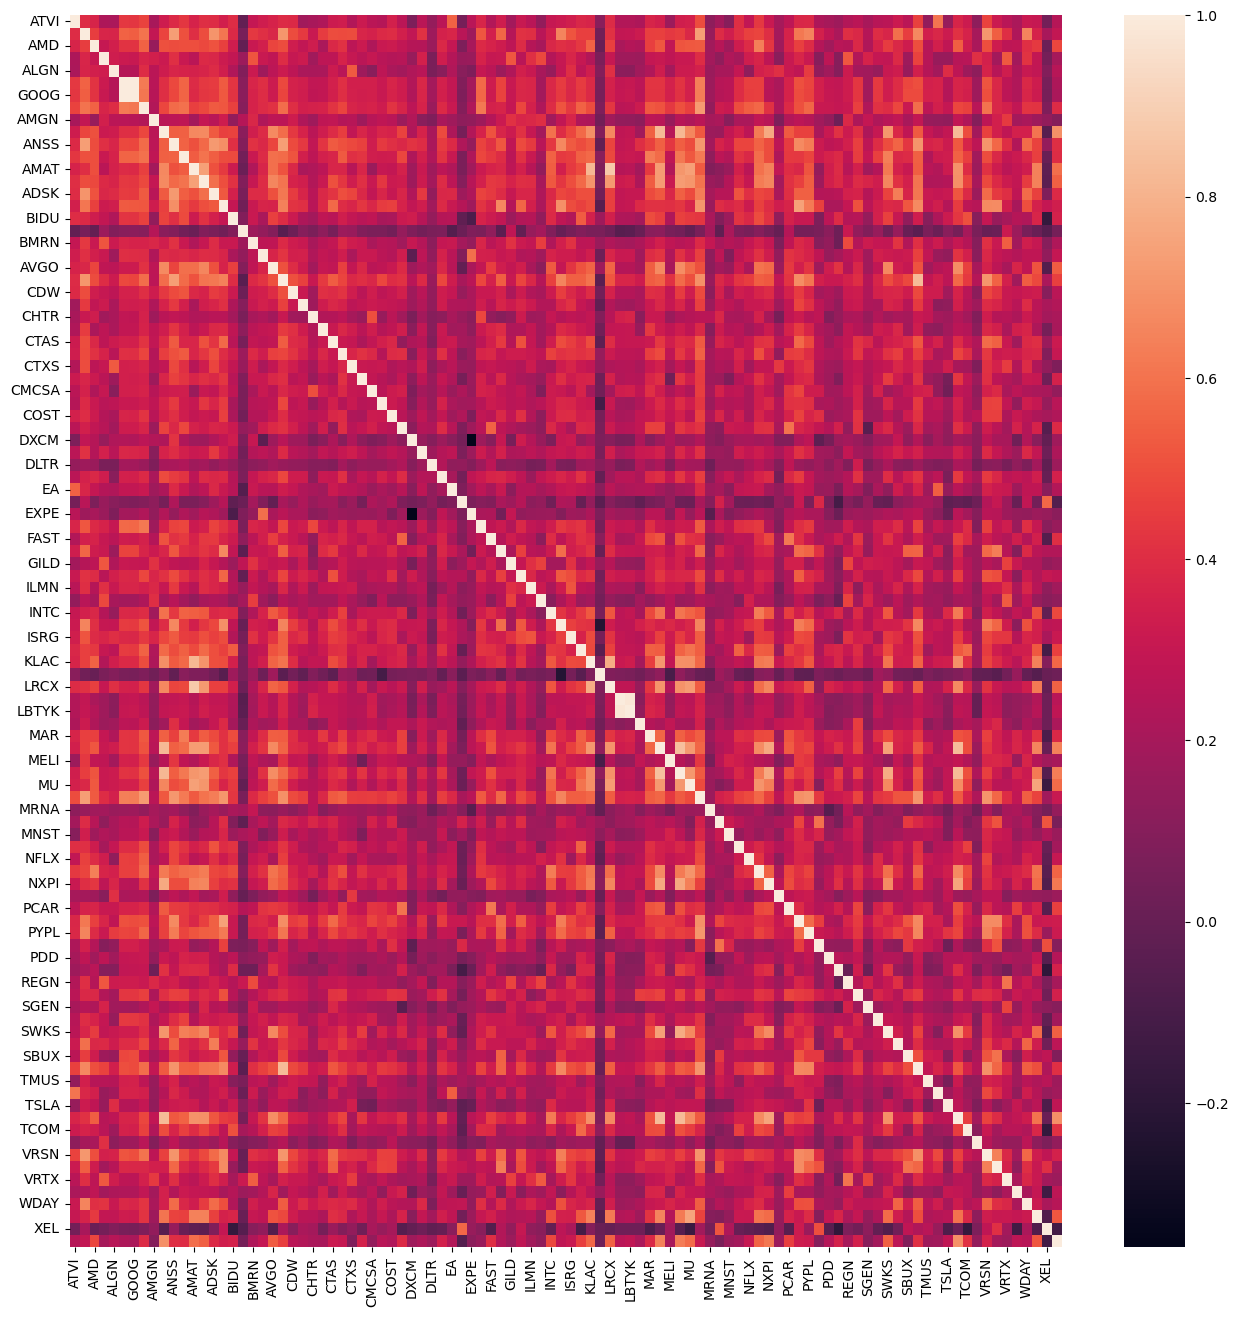

In [37]:
plt.figure(figsize=(16,16))
sns.heatmap(p_2019)
plt.show()

#### Heatmap to show correlation/similarity in returns of stocks for 2020

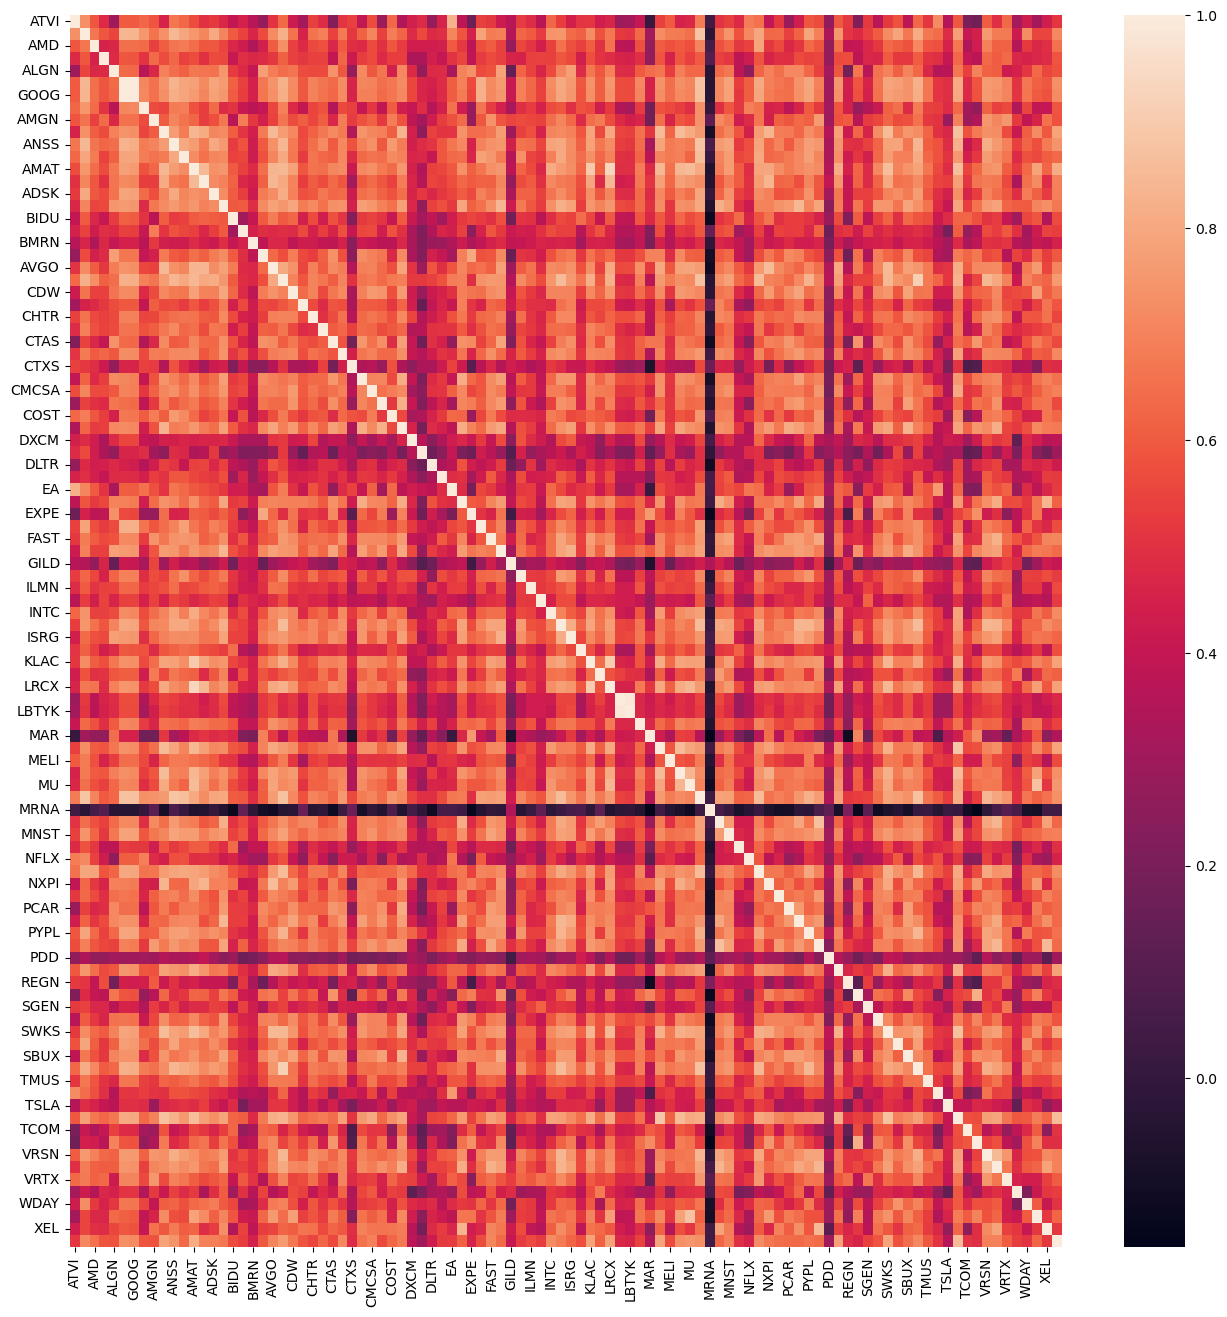

In [38]:
plt.figure(figsize=(16,16))
sns.heatmap(p_2020)
plt.show()